In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline

# Progress bar
from tqdm.auto import trange, tqdm

In [2]:
import webbpsf_ext

from webbpsf_ext.webbpsf_ext_core import _transmission_map
from webbpsf_ext.image_manip import frebin, fourier_imshift
from webbpsf_ext.image_manip import pad_or_cut_to_size
from webbpsf_ext.coords import rtheta_to_xy

webbpsf_ext.setup_logging('WARN')

webbpsf_ext log messages of level WARN and above will be shown.
webbpsf_ext log outputs will be directed to the screen.


In [3]:
from scipy.interpolate import interp1d

In [4]:


class NIRCam_PSF():
    
    from webbpsf_ext import NIRCam_ext
    
    def __init__(self, filter, image_mask, fov_pix, oversample=2, 
                 sp=None, use_coeff=True, date=None, **kwargs):
        """ Class to generate off-axis coronagraphic PSF

        This object provides the ability to generate a synthetic NIRCam coronagraphic
        PSF using webbpsf and webbpsf_ext at an arbitrary location relative to the 
        occulting mask, taking into account mask attentuation near the IWA.

        There are multiple ways to estimate these PSFs, either through extrapolation
        from the theoretical occulting mask transmission (fastest), using the 
        webbpsf_ext PSF coefficients (intermediate speed), or on-the-fly calculations
        using webbpsf (slowest, but most accurate). 

        Includes the ability to use date-specific OPD maps as generated by the JWST
        wavefront sensing group. Simply set use_coeff=False, and supply a date in ISO 
        format.

        All resulting PSFs were normalized such that their total intensity is 1.0
        at the telescope entrance pupil. So, the final intensity of these PSFs
        include throughput attentuation at intermediate optics such as the NIRCam
        Lyot stops in the pupil wheels. 

        Parameters
        ==========
        filter : str
            NIRCam filter (e.g., F335M)
        image_mask : str
            NIRCam coronagraphic occulting mask (e.g., MASK335R)
        fov_pix : int
            PSF pixel size. Suggest odd values for centering PSF in middle of a pixel
            rather than pixel corner / boundaries.
        oversample : int
            Size of oversampling.
        sp : pysynphot spectrum
            Spectrum to use for PSF wavelenght weighting. If None, then default is G2V.
        use_coeff : bool
            Generate PSFs from webbpsf_ext coefficient library. If set to False, then
            will use webbpsf to generate PSFs on-the-fly, opening up the ability to
            use date-specific OPD files via the `date` keyword.
        date : str or None
            Date time in UTC as ISO-format string, a la 2022-07-01T07:20:00.
            If not set, then default webbpsf OPD is used (e.g., RevAA).
        """

        # Choose Lyot stop based on coronagraphic mask input
        if image_mask is None:
            pupil_mask = None
        else:
            pupil_mask = 'CIRCLYOT' if image_mask[-1]=='R' else 'WEDGELYOT'
            
        nrc_on = self.NIRCam_ext(filter=filter, image_mask=image_mask, pupil_mask=pupil_mask,
                                 fov_pix=fov_pix, oversample=oversample, **kwargs)

        nrc_off = self.NIRCam_ext(filter=filter, image_mask=None, pupil_mask=pupil_mask,
                                  fov_pix=fov_pix, oversample=oversample, **kwargs)

        # Load date-specific OPD files?
        if not use_coeff and (date is not None):
            nrc_on.load_wss_opd_by_date(date=date, choice='before', verbose=False, plot=False)
            nrc_off.load_wss_opd_by_date(date=date, choice='before', verbose=False, plot=False)
        
        # Generating initial PSFs...
        print('Generating initial PSFs...')
        if use_coeff:
            nrc_on.options['jitter_sigma'] = 0
            nrc_off.options['jitter_sigma'] = 0
            nrc_on.gen_psf_coeff()
            nrc_off.gen_psf_coeff()
            func_on = nrc_on.calc_psf_from_coeff
            func_off = nrc_off.calc_psf_from_coeff
            nrc_on.gen_wfemask_coeff(large_grid=True)
        else:
            func_on = nrc_on.calc_psf
            func_off = nrc_off.calc_psf
            nrc_on.options['jitter'] = 'gaussian'
            nrc_on.options['jitter_sigma'] = 0.003
            nrc_off.options['jitter'] = 'gaussian'
            nrc_off.options['jitter_sigma'] = 0.003

        # Renormalize spectrum to have 1 e-/sec within bandpass to obtain normalized PSFs
        if sp is not None:
            sp = sp.renorm(1, 'counts', nrc_on.bandpass)
                        
        # On axis PSF
        if image_mask[-1]=='R':
            self.psf_on = func_on(sp=sp, return_oversample=True, return_hdul=False)
        elif image_mask[-1]=='B':
            # Need an array of PSFs along bar center
            xvals = np.linspace(-8,8,9)
            self.psf_bar_xvals = xvals
            
            psf_bar_arr = []
            for xv in tqdm(xvals, desc='Bar PSFs', leave=False):
                psf = func_on(sp=sp, return_oversample=True, return_hdul=False, 
                              coord_vals=(xv,0), coord_frame='idl')
                psf_bar_arr.append(psf)
            self.psf_on = np.array(psf_bar_arr)
        else:
            raise 
            
        # Off axis PSF
        self.psf_off = func_off(sp=sp, return_oversample=True, return_hdul=False)

        # Center PSFs
        self._recenter_psfs()

        # Store NIRCam classes
        self.nrc_on  = nrc_on
        self.nrc_off = nrc_off
        
        # PSF generation functions for later use
        self._use_coeff = use_coeff
        self._func_on  = func_on
        self._func_off = func_off

        self.sp = sp
        
    @property
    def fov_pix(self):
        return self.nrc_on.fov_pix
    @property
    def oversample(self):
        return self.nrc_on.oversample

    @property
    def filter(self):
        return self.nrc_on.filter
    @property
    def image_mask(self):
        return self.nrc_on.image_mask
    @property
    def pupil_mask(self):
        return self.nrc_on.pupil_mask
    
    @property
    def use_coeff(self):
        return self._use_coeff

    @property
    def bandpass(self):
        return self.nrc_on.bandpass

    def _calc_psf_off_shift(self, xysub=10):
        """Calculate oversampled pixel shifts using off-axis PSF and Gaussian centroiding"""

        from astropy.modeling import models, fitting

        xv = yv = np.arange(xysub)
        xgrid, ygrid = np.meshgrid(xv, yv)
        xc, yc = (xv.mean(), yv.mean())

        psf_template = pad_or_cut_to_size(self.psf_off, xysub+10)

        xoff = 0
        yoff = 0
        for ii in range(2):
            psf_off = pad_or_cut_to_size(psf_template, xysub)

            # Fit the data using astropy.modeling
            p_init = models.Gaussian2D(amplitude=psf_off.max(), x_mean=xc, y_mean=yc, x_stddev=1, y_stddev=2)
            fit_p = fitting.LevMarLSQFitter()

            pfit = fit_p(p_init, xgrid, ygrid, psf_off)
            xcen_psf = xc - pfit.x_mean.value
            ycen_psf = yc - pfit.y_mean.value

            # Accumulate offsets
            xoff += xcen_psf
            yoff += ycen_psf

            # Update initial PSF location
            psf_template = fourier_imshift(psf_template, xcen_psf, ycen_psf, pad=True)

        # Save to attribute
        self._xy_off_to_cen = (xoff, yoff)

    
    def _recenter_psfs(self, **kwargs):
        """Recenter PSFs by centroiding on off-axis PSF and shifting both by same amount"""

        # Calculate shift
        self._calc_psf_off_shift(**kwargs)
        xoff, yoff = self._xy_off_to_cen
        
        # Perform recentering
        self.psf_on = fourier_imshift(self.psf_on, xoff, yoff, pad=True)
        self.psf_off = fourier_imshift(self.psf_off, xoff, yoff, pad=True)

    
    def rth_to_xy(self, r, th, PA_V3=0, frame_out='idl'):
        """ Convert (r,th) location to (x,y) in idl coords

        Assume (r,th) in coordinate system with North up East to the left.
        Then convert to NIRCam detector orientation (idl coord frame).
        Units assumed to be in arcsec.

        Parameters
        ==========
        r : float or ndarray
            Radial offst from mask center.
        th : float or ndarray
            Position angle (positive angles East of North) in degrees.
            Can also be an array; must match size of `r`.
        PA_V3 : float
            V3 PA of telescope.
        frame_out : str
            Coordinate frame of output. Default is 'idl'

                * 'tel': arcsecs V2,V3
                * 'sci': pixels, in DMS axes orientation; aperture-dependent
                * 'det': pixels, in raw detector read out axes orientation
                * 'idl': arcsecs relative to aperture reference location.
        """

        # Convert to aperture PA
        PA_ap = PA_V3 + self.nrc_on.siaf_ap.V3IdlYAngle
        # Get theta relative to detector orientation (idl frame)
        th_fin = th - PA_ap
        # Return (x,y) in idl frame
        xidl, yidl = rtheta_to_xy(r, th_fin)

        if frame_out=='idl':
            return (xidl, yidl)
        else:
            return self.nrc_on.siaf_ap.convert(xidl, yidl, 'idl', frame_out)

    
    def gen_psf_idl(self, coord_vals, coord_frame='idl', quick=True, sp=None,
                    return_oversample=False, do_shift=False):
        """ Generate offset PSF in detector frame

        Generate a PSF with some (x,y) position in some coordinate frame (default idl).


        Parameters
        ==========
        coord_vals : tuple or None
            Coordinates (in arcsec or pixels) to calculate field-dependent PSF.
            If multiple values, then this should be an array ([xvals], [yvals]).
        coord_frame : str
            Type of input coordinates. Default is 'idl'

                * 'tel': arcsecs V2,V3
                * 'sci': pixels, in DMS axes orientation; aperture-dependent
                * 'det': pixels, in raw detector read out axes orientation
                * 'idl': arcsecs relative to aperture reference location.

        quick : bool
            Use linear combination of on-axis and off-axis PSFs to generate
            PSF as a function of corongraphic mask throughput. This is much
            faster (1 ms) than the standard calculations using coefficients (0.5 s) 
            or on-the-fly calcs w/ webbpsf (10 s).
        sp : pysynphot spectrum
            Manually specify spectrum to get a desired wavelength weighting. 
            Only applicable if ``quick=False``. If not set, defaults to ``self.sp``.
        return_oversample : bool
            Return the oversampled version of the PSF?
        do_shift : bool
            If True, will offset PSF by appropriate amount from center. Otherwise,
            returns PSF in center of image.
        """

        # Work with oversampled pixels and downsample at end
        siaf_ap = self.nrc_on.siaf_ap
        osamp = self.nrc_on.oversample
        ny = nx = self.fov_pix * osamp

        # Renormalize spectrum to have 1 e-/sec within bandpass to obtain normalized PSFs
        if sp is not None:
            sp = sp.renorm(1, 'counts', self.bandpass)
        
        if quick:

            t_temp, cx_idl, cy_idl = _transmission_map(self.nrc_on, coord_vals, coord_frame)
            trans = t_temp**2

            # Linear combination of min/max to determine PSF
            # Get a and b values for each position
            avals = trans
            bvals = 1 - avals

            if self.image_mask[-1]=='B':
                # Interpolation function
                xvals = self.psf_bar_xvals
                psf_arr = self.psf_on
                finterp = interp1d(xvals, psf_arr, kind='linear', fill_value='extrapolate', axis=0)
                psf_on = finterp(cx_idl)
            else:
                psf_on = self.psf_on
            psf_off = self.psf_off

            psfs = avals.reshape([-1,1,1]) * psf_off.reshape([1,ny,nx]) \
                 + bvals.reshape([-1,1,1]) * psf_on.reshape([1,ny,nx])
        
        else:
            calc_psf = self._func_on
            sp = self.sp if sp is None else sp
            psfs = calc_psf(sp=sp, coord_vals=coord_vals, coord_frame=coord_frame,
                            return_oversample=True, return_hdul=False)

            # Ensure 3D cube
            psfs = psfs.reshape([-1,ny,nx])

            # Perform shift to center
            # Already done for quick case
            xoff, yoff = self._xy_off_to_cen
            psfs = fourier_imshift(psfs, xoff, yoff, pad=True)

        if do_shift:
            # Get offset in idl frame
            if coord_frame=='idl':
                xidl, yidl = coord_vals
            else:
                xidl, yidl = siaf_ap.convert(coord_vals[0], coord_vals[1], coord_frame, 'idl')

            # Convert to pixels for shifting
            dx_pix = np.array([osamp * xidl / siaf_ap.XSciScale]).ravel()
            dy_pix = np.array([osamp * yidl / siaf_ap.YSciScale]).ravel()

            psfs_sh = []
            for i, im in enumerate(psfs):
                psf = fourier_imshift(im, dx_pix[i], dy_pix[i], pad=True)
                psfs_sh.append(psf)
            psfs = np.asarray(psfs_sh)

        # Resample to detector pixels?
        if not return_oversample:
            psfs = frebin(psfs, scale=1/osamp)

        return psfs.squeeze()


    def gen_psf_rth(self, r, th, PA_V3=0, return_oversample=False, do_shift=True, **kwargs):
        """ Generate offset PSF rotated by PA to N-E orientation

        Generate a PSF for some (x,y) detector position in N-E sky orientation.


        Parameters
        ==========
        r : float or ndarray
            Radial offst from mask center.
        th : float or ndarray
            Position angle (positive angles East of North) in degrees.
            Can also be an array; must match size of `r`.
        PA_V3 : float
            V3 PA of telescope.
        return_oversample : bool
            Return the oversampled version of the PSF?
        do_shift : bool
            If True, will offset PSF by appropriate amount from center. Otherwise,
            returns PSF in center of image.

        Keyword Args
        ============
        quick : bool
            Use linear combination of on-axis and off-axis PSFs to generate
            PSF as a function of corongraphic mask throughput. This is much
            faster (1 ms) than the standard calculations using coefficients (0.5 s) 
            or on-the-fly calcs w/ webbpsf (10 s).
        sp : pysynphot spectrum
            Manually specify spectrum to get a desired wavelength weighting. 
            Only applicable if ``quick=False``. If not set, defaults to ``self.sp``.
        """

        from scipy.ndimage.interpolation import rotate

        # Work with oversampled pixels and downsample at end
        siaf_ap = self.nrc_on.siaf_ap
        osamp = self.nrc_on.oversample
        ny = nx = self.fov_pix * osamp

        # Locations in aperture ideal frame to produce PSFs
        xidl, yidl = self.rth_to_xy(r, th, PA_V3=PA_V3, frame_out='idl')

        # Perform shift in idl frame then rotate to sky coords
        psfs = self.gen_psf_idl((xidl, yidl), coord_frame='idl', do_shift=do_shift, 
                                return_oversample=True, **kwargs)

        if do_shift:
            # Shifting PSF, means rotate such that North is up
            psfs = psfs.reshape([-1,ny,nx])
            # Get aperture position angle
            PA_ap = PA_V3 + siaf_ap.V3IdlYAngle
            psfs = rotate(psfs, -PA_ap, reshape=False, mode='constant', cval=0, axes=(-1,-2))

        # Resample to detector pixels?
        if not return_oversample:
            psfs = frebin(psfs, scale=1/osamp)

        return psfs.squeeze()




In [5]:
sp = webbpsf_ext.stellar_spectrum('G2V')

filt = 'F300M' 
image_mask = 'MASK335R'

fov_pix = 321
osamp = 2

kwargs = {
    'oversample' : osamp,
    'date' : '2022-07-01T12:00:00',
    'sp' : sp,
}

# Initialize using webbpsf_ext coefficients
%time nrc_coeff = NIRCam_PSF(filt, image_mask, fov_pix, use_coeff=True, **kwargs)

# Initialize using webbpsf date-specific OPDs
%time nrc_latest = NIRCam_PSF(filt, image_mask, fov_pix, use_coeff=False, **kwargs)

Generating initial PSFs...
CPU times: user 12.3 s, sys: 11.4 s, total: 23.6 s
Wall time: 8.21 s
INFO: MAST API token accepted, welcome Jarron Leisenring [astroquery.mast.auth]
[astroquery:INFO] MAST API token accepted, welcome Jarron Leisenring
Generating initial PSFs...
CPU times: user 1min 43s, sys: 25.9 s, total: 2min 9s
Wall time: 22.6 s


0.18876181014263202 0.0008056867926509878
0.18878204429680742 0.0010574865499464478


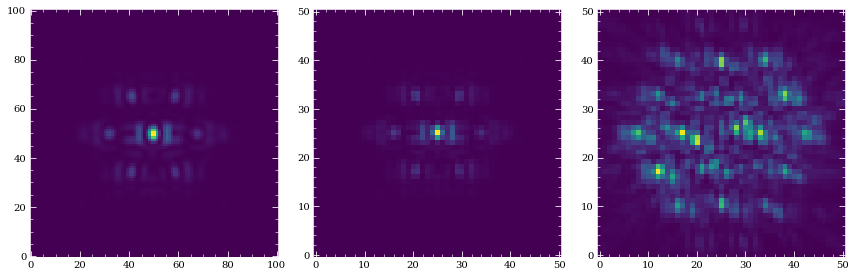

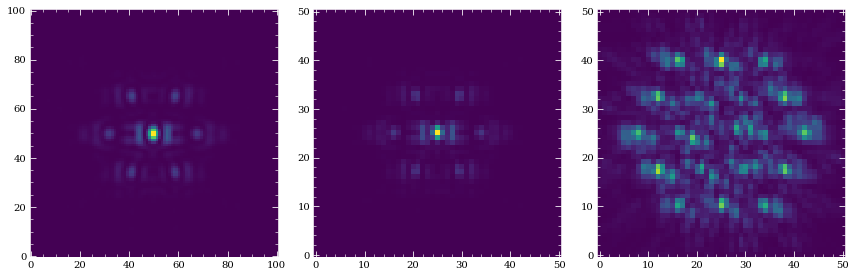

In [6]:
# Verify that the off-axis PSFs are correctly centered
for nrc in [nrc_coeff, nrc_latest]:

    psf_off_over = nrc.psf_off
    psf_off = frebin(psf_off_over, scale=1/osamp)
    psf_on = frebin(nrc.psf_on, scale=1/osamp)

    print(psf_off.sum(), psf_on.sum())

    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].imshow(pad_or_cut_to_size(psf_off_over, 101))
    axes[1].imshow(pad_or_cut_to_size(psf_off, 51))
    axes[2].imshow(pad_or_cut_to_size(psf_on, 51))

    for ax in axes:
        # Tick Marks
        ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
        ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

        ax.tick_params(axis='both', color='white', which='both')
        for k in ax.spines.keys():
            ax.spines[k].set_color('white')

    fig.tight_layout()

In [7]:
# Test multiple ways of creating a PSF
# These should all have similiar results (fingers crossed)

# Create PSF at some location from mask, assuming North is up and East to the left
r_off = 0.1  # Radial distance from mask center (arcsec)
th    = 45    # Position angle (positive angles East of North) in degrees.
PA_V3 = -15   # V3 PA of observation

# Utilizing webbpsf_ext coefficients
%time psf_coeff_quick = nrc_coeff.gen_psf_rth(r_off, th, PA_V3=PA_V3, quick=True)
%time psf_coeff_slow  = nrc_coeff.gen_psf_rth(r_off, th, PA_V3=PA_V3, quick=False)

# Using webbpsf latest OPD maps
%time psf_latest_quick = nrc_latest.gen_psf_rth(r_off, th, PA_V3=PA_V3, quick=True)
%time psf_latest_slow  = nrc_latest.gen_psf_rth(r_off, th, PA_V3=PA_V3, quick=False)

CPU times: user 67.2 ms, sys: 0 ns, total: 67.2 ms
Wall time: 66.2 ms
CPU times: user 3.08 s, sys: 4.67 s, total: 7.75 s
Wall time: 581 ms
CPU times: user 64.8 ms, sys: 399 µs, total: 65.2 ms
Wall time: 65.1 ms
CPU times: user 53.2 s, sys: 13.5 s, total: 1min 6s
Wall time: 11.3 s


0.0009389065908954234 6.9419805746306e-06
0.0010210290404947915 1.0235456358081403e-05
0.001191112573535807 6.672421841940685e-06
0.0012490853728029303 9.491586331946641e-06


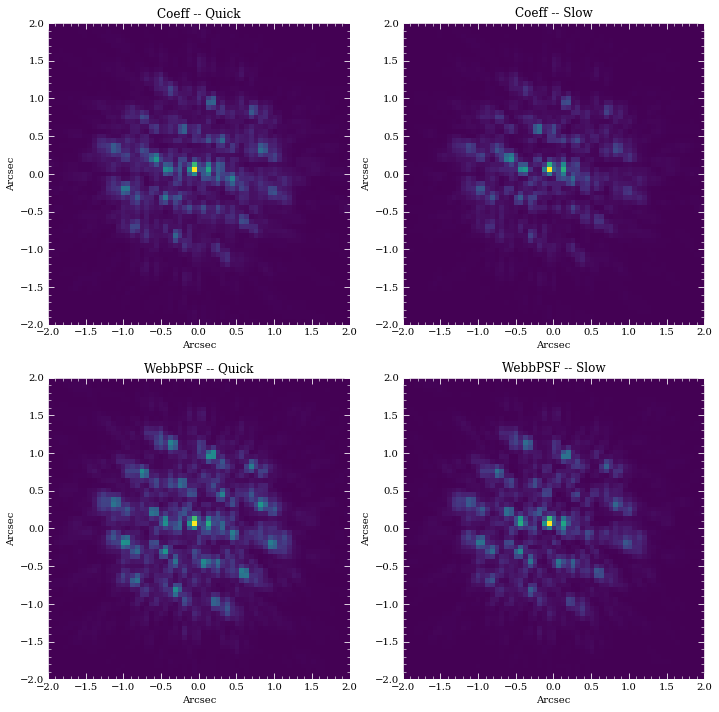

In [8]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
axes = axes.flatten()

psf_list = [psf_coeff_quick, psf_coeff_slow, psf_latest_quick, psf_latest_slow]
titles = ['Coeff -- Quick', 'Coeff -- Slow', 'WebbPSF -- Quick', 'WebbPSF -- Slow']
for i, im in enumerate(psf_list):
    ax = axes[i]

    ny, nx = im.shape
    extent = np.array([-nx/2, nx/2, -ny/2, ny/2]) * nrc_coeff.nrc_on.pixelscale
    ax.imshow(im, extent=extent)

    ax.set_title(titles[i])
    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')

    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    
    # Tick Marks
    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')

    print(im.sum(), im.max())

fig.tight_layout()

In [9]:
# Test multiple ways of creating a PSF
# These should all have similiar results (fingers crossed)

# Create PSF at some location from mask, assuming North is up and East to the left
r_off = 0.5  # Radial distance from mask center (arcsec)
th    = 45    # Position angle (positive angles East of North) in degrees.
PA_V3 = 30   # V3 PA of observation

# Utilizing webbpsf_ext coefficients
%time psf_coeff_quick = nrc_coeff.gen_psf_rth(r_off, th, PA_V3=PA_V3, quick=True)
%time psf_coeff_slow  = nrc_coeff.gen_psf_rth(r_off, th, PA_V3=PA_V3, quick=False)

# Using webbpsf latest OPD maps
%time psf_latest_quick = nrc_latest.gen_psf_rth(r_off, th, PA_V3=PA_V3, quick=True)
%time psf_latest_slow  = nrc_latest.gen_psf_rth(r_off, th, PA_V3=PA_V3, quick=False)

CPU times: user 55.9 ms, sys: 30 µs, total: 55.9 ms
Wall time: 54.9 ms
CPU times: user 3.09 s, sys: 4.45 s, total: 7.54 s
Wall time: 556 ms
CPU times: user 53.7 ms, sys: 0 ns, total: 53.7 ms
Wall time: 53.6 ms
CPU times: user 54.3 s, sys: 13.6 s, total: 1min 7s
Wall time: 11.4 s


0.050329987561930835 0.0018811051780744147
0.05262052613660154 0.0019249346626607233
0.05052182375056455 0.0019013960739926094
0.05008037838718156 0.0018529196942597315


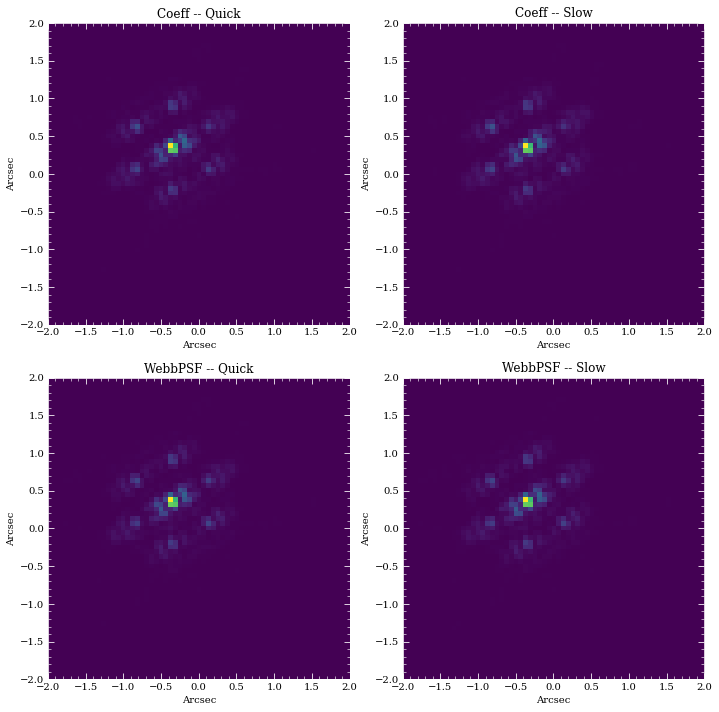

In [10]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
axes = axes.flatten()

psf_list = [psf_coeff_quick, psf_coeff_slow, psf_latest_quick, psf_latest_slow]
titles = ['Coeff -- Quick', 'Coeff -- Slow', 'WebbPSF -- Quick', 'WebbPSF -- Slow']
for i, im in enumerate(psf_list):
    ax = axes[i]

    ny, nx = im.shape
    extent = np.array([-nx/2, nx/2, -ny/2, ny/2]) * nrc_coeff.nrc_on.pixelscale
    ax.imshow(im, extent=extent)

    ax.set_title(titles[i])
    ax.set_xlabel('Arcsec')
    ax.set_ylabel('Arcsec')

    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    
    # Tick Marks
    ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

    ax.tick_params(axis='both', color='white', which='both')
    for k in ax.spines.keys():
        ax.spines[k].set_color('white')

    print(im.sum(), im.max())

fig.tight_layout()